# Week 1: design and data representation
This week's tutorial/assignment will be about the basics of pattern analysis. More specifically, we'll discuss the difference in modelling/estimating patterns in within- and between-subject analyses, and subsequently how to load, transform, and represent these patterns for use in pattern analyses.

Additionally, we'll discuss some new programming concepts (mostly object-oriented programming), as this will become more and more important as you're going to learn how to program everything yourself in Python. 

## 1. Designs for pattern analyses
There are many ways in which you can categorize different types of pattern analyses (a topic which you'll work on in Thursdays's seminar), but one of the most basic categorizations is in terms of whether analyses are **within-subject** or **between-subject**. The major distinction revolves around whether you want to investigate an (experimental) factor that varies or is manipulated within subjects or that varies across subjects (i.e. individual differences or experimental between-subject designs). 

As explained in the lecture, there are three ways to extract patterns from fMRI data: 

1. extract activity at a certain timepoint (e.g. 3 TRs after stimulus presentation);
2. extract the *average* activity within a time-range (e.g. 2-4 TRs after stimulus presentation);
3. extract patterns of $\beta$-estimates by fitting a HRF per trial using the GLM you're familiar with; 

In the first part of this tutorial, you will see how the design matrices for the GLM in method 3 look like for both (single-trial) within-subject analyses and between-subject analyses. 

### 1.2. Within-subject designs
Often, trials in within-subject designs are modelled as separate regressors in a first-level analysis. In other words, you model each trial as a separate (*single!*) HRF-response. Below, we included an image of a single-trial design (of the hypothetical faces vs. houses experiment) as created in FSL:<img src="single_trial_design.png" alt="Drawing" heigth="100" width="400">

As you can see, each trial (either a face or a house) gets it's own regressor. Then, as depicted below the design matrix, a contrast-against-baseline is created for each regressor (trial), such that you can extract patterns of t-values (or z-values) for each trial.

Before you go on, make sure you understand this image! This image represents basically all you need to understand about single-trial designs. 

#### Implement your own single-trial design
In this section, you'll create your own single-trial matrix corresponding to a (real) working memory experiment (similar to the one described in Monday's lecture). In this experiment, one condition ("ACTIVE") subjects had to remember a configuration of bars and after a retention period had to respond whether one of the bars has changed in the test-image or not. In the other condition ("PASSIVE") they just watched a blank screen and had to respond with a random answer. The experiment is depicted schematically below:

![test](WM_example.png) 

In total, subjects performed 40 trials, of which 32 were of the "ACTIVE" condition and 8 were of the "PASSIVE" condition. Below, we'll load the onsets (and durations and conditions).

In [84]:
# First some imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [87]:
# Numpy array with onsets (column 1), durations (column 2), and conditions (column 3)
# N.B.: condition 0 = passive, condition 1 = active
onsets = np.loadtxt('onsets.csv').astype(int)
print("Onset Duration Condition")
print(onsets)

Onset Duration Condition
[[  8   6   1]
 [ 20   6   1]
 [ 26   6   1]
 [ 36   6   0]
 [ 42   6   1]
 [ 52   6   1]
 [ 60   6   1]
 [ 66   6   1]
 [ 72   6   1]
 [ 78   6   1]
 [ 86   6   1]
 [ 92   6   1]
 [100   6   1]
 [106   6   0]
 [112   6   1]
 [118   6   1]
 [126   6   0]
 [134   6   1]
 [140   6   1]
 [150   6   1]
 [156   6   0]
 [162   6   0]
 [172   6   1]
 [180   6   1]
 [188   6   1]
 [194   6   1]
 [204   6   0]
 [210   6   1]
 [216   6   1]
 [222   6   1]
 [228   6   1]
 [238   6   1]
 [244   6   1]
 [252   6   1]
 [258   6   1]
 [264   6   1]
 [272   6   0]
 [280   6   0]
 [296   6   1]
 [302   6   1]]


<div class='alert alert-warning'>
**ToDo**: Practice your numpy-skills! How would you calculate how many active-trials and how many passive-trials there were? 
</div>

In [85]:
# Implement your ToDo here


Remember, the onsets (and duration) are here defined in seconds (not TRs). Let's assume that the fMRI-run has a TR of 2. Now, we can convert (very easily!) the onsets/durations-in-seconds to onsets/durations-in-TRs.

<div class='alert alert-warning'>
**ToDo**: Convert the onsets and durations from seconds to TRs.
</div>

In [88]:
# ToDo
onsets[:, :2] /= 2

Now, as you might remember, for each regressor we need to create a regressor of zeros and ones, in which the ones represent the moments in which the particular trial was presented. Remember, if a stimulus lasted 6 seconds (i.e. 3 TRs), make sure that your regressor also models your event for this duration! 

So, for example, if you have a (hypothetical) run with a duration of 15 TRs, and you show a stimulus at TR=3 for the duration of 3 TRs (i.e. 6 seconds), then you'd code your regressor as:

`[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

<div class='alert alert-warning'>
**ToDo**: Below, we initialized a stimulus vector (`stim_vec`) of shape=[40, 162], i.e. trials x timepoints (this run was 162 TRs long), with zeros. Each of the 40 rows represents one trial. Loop over the rows of the `stim_vec` matrix and fill the times at onset till the onset + 2 TRs with ones. Remember, the first index in Python is zero (not 1!).
</div>

In [8]:
# Fill the stim_vec variable with ones at the indices of the onsets per trial!
stim_vec = np.zeros((162, 40))
for idx, onset in enumerate(onsets[:, 0]):
    stim_vec[range((onset -1), (onset + 1)), idx] = 1

Now, we only need to convolve an HRF with the stimulus-vectors and we'll have a complete single-trial design! Don't worry, we do this for you. We'll also plot it to see how it looks.

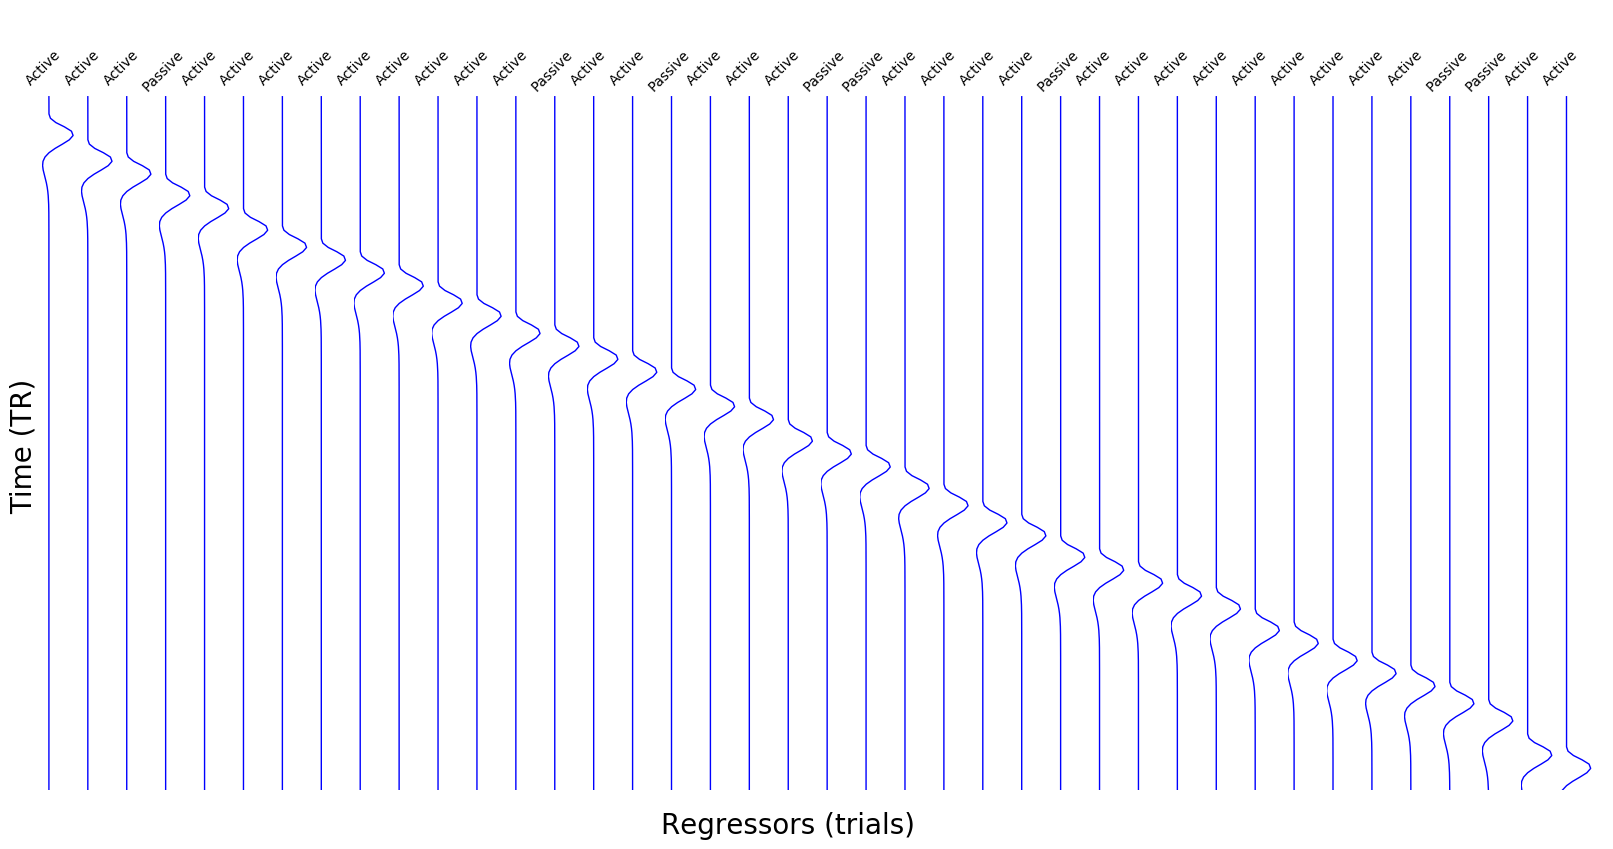

In [89]:
from functions import double_gamma

hrf = double_gamma(range(162))

# List comprehension (fancy for-loop) + stack results back to a matrix
X = np.vstack([np.convolve(hrf, stim_vec[:, i], 'full')[:162] for i in range(40)]).T

plt.figure(figsize=(20, 10))
for plot in range(40):
    plt.subplot(1, 40, plot+1)
    plt.plot(X[:, plot], range(X.shape[0])[::-1])
    plt.axis('off')
    plt.text(-2, 170, 'Active' if onsets[plot, 2] else 'Passive', rotation=45)

plt.text(-60, -10, 'Regressors (trials)', ha='center', fontsize=20)
plt.text(-120, 80, 'Time (TR)', va='center', rotation='vertical', fontsize=20)
plt.show()

As explained in the lecture, we can use this design to extract patterns of $\beta$-values for each regressor. But [it has been shown](http://www.sciencedirect.com/science/article/pii/S1053811910007834) that converting $\beta$-values to t-values often creates more stable and robust patterns. As you might remember from "Neuroimaging: fMRI", $\beta$-values can be normalized to t-values by defining a contrast-against-baseline that is subsequently used in the formula for the t-value. 

Suppose I want to convert the patterns of $\beta$-values *for each trial* in the design above to t-values, how would my contrast-matrix look like? (Hint: check out the first image of this notebook.)

<div class='alert alert-warning'>
**ToDo**: create a design matrix in which each row represents the contrast-against-baseline-vector of a single trial of the within-subject design above. (Hint: check out the `numpy.eye()` function)
</div>

In [ ]:
# Do your ToDo here

### 1.3. Between-subject designs
Between-subject designs are way more 'simple' than within-subject designs. Basically, they're the same as traditional 'activation-based' (univariate) designs in which each condition (*not* trial!) gets its own regressor. Thus, the final design-matrix is, in this case of the WM experiment, only of size 162 x 2 (one 'active' regressor, one 'passive' regressor).

<div class='alert alert-warning'>
**ToDo**: Below, we again initialized a stimulus-vector matrix with zeros. Now fill it again with ones at times of the stimulus-onsets of each condition.   
</div>

In [11]:
stim_vec_between = np.zeros((162, 2))
passive_idx = onsets[onsets[:, 2] == 0]
active_idx = onsets[onsets[:, 2] == 1]

stim_vec_between[passive_idx - 1, 0] = 1
stim_vec_between[passive_idx, 0] = 1
stim_vec_between[passive_idx + 1 , 0] = 1

stim_vec_between[active_idx -1 , 1] = 1
stim_vec_between[passive_idx, 1] = 1
stim_vec_between[passive_idx + 1 , 1] = 1

Now, given that you succesfully filled the stim_vec_between variable with ones, let's plot it again to see how this between-subject design looks like.

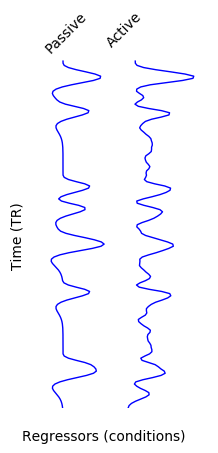

In [76]:
Xb = np.vstack([np.convolve(hrf, stim_vec_between[:, i], 'full')[:162] for i in range(2)]).T

plt.figure(figsize=(2, 5))
for plot in range(2):
    plt.subplot(1, 2, plot+1)
    plt.plot(Xb[:, plot], range(Xb.shape[0])[::-1])
    plt.text(-2, 180, 'Passive' if plot == 0 else 'Active', rotation=45)
    plt.axis('off')
plt.text(-2, -15, 'Regressors (conditions)', ha='center', fontsize=10)
plt.text(-8, 80, 'Time (TR)', va='center', rotation='vertical', fontsize=10)
plt.show()

Hopefully, by creating design matrices for pattern extraction in within- and between-subject pattern analyses, you understand the differences between these two types better. 

In a real-life pattern analysis project, however, you'd probably just use FSL's FEAT to estimate the $\beta$\t-values of each trial/conditoin. We've done this for you: in the `part1`-folder (`/home/nim_?/week_1/part1`) you find two `.feat`-directories of a single subject - one as the result of a within-subject design and one as the result of a between-subject design.  

<div class='alert alert-info'>
**ToThink**: check out the files and folders in both directories. Look at both designs (double-click `design.png`) and check out the stats folders. Make sure you understand the differences!
</div>

So far, we demonstrated the main differences between how you would define GLM design matrices to extract patterns for within- and between-subject pattern analyses. Now, we're going to digress slightly (but for a good reason) and talk about object-oriented programming in Python (something you'll encounter a lot in the coming weeks!).

## 2. Object-oriented programming
Python is a so-called `object-oriented` language. What this means is that *everything in Python is some kind of 'object'*, each having it's own *class*.

- methods interact with the object itself
- plans vs. buildings

In [95]:
class Class(object):
    
    def __init__(self):
        pass

print(type(Class()))

<class '__main__.Class'>


In [97]:
a = 'test'
a = list()

**ToThink**: why must between-subject patterns be in standard space?